# Jaxwell

Jaxwell is JAX + Maxwell, enabling us to treat nanophotonic inverse design problems as ML training jobs.

This example builds an ML model that takes as inputs the structure $z$ and the current sources $b$, performs an electromagnetic simulation, and computes an objective loss, $f(z, b)$.
Critically, it also allows for the the gradients $\partial f / \partial z$ and $\partial f / \partial b$ to be easily computed, so that the objective $f$ can be minimized.

# Preamble

Check to see that we have a GPU, enable JAX's 64-bit mode, install Jaxwell, and import dependencies.

In [1]:
# Check to see what GPU we have.
!nvidia-smi

Thu Sep 21 13:27:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
# Install Jaxwell from github.
!pip install git+https://github.com/jan-david-fischbach/jaxwell.git

Found existing installation: jaxwell 0.1
Uninstalling jaxwell-0.1:
  Successfully uninstalled jaxwell-0.1
  Cloning https://github.com/jan-david-fischbach/jaxwell.git to /tmp/pip-req-build-ut7fxv6p
  Running command git clone --filter=blob:none --quiet https://github.com/jan-david-fischbach/jaxwell.git /tmp/pip-req-build-ut7fxv6p
  Resolved https://github.com/jan-david-fischbach/jaxwell.git to commit 776d468ea1cdf7ec6cfb6fa1a6b33f859eaf6444
  Preparing metadata (setup.py) ... done
  Created wheel for jaxwell: filename=jaxwell-0.1-py3-none-any.whl size=22254 sha256=899e86c5263e8c7cb8dce4b6371cf2aa5c5a94a0ed67af5c536b306a91577fb0
  Stored in directory: /tmp/pip-ephem-wheel-cache-tygnq0v9/wheels/be/fe/5f/cc2d08f42ca0ceff9f93e6ee71f3c89df0488db6534ddcbbb0
Successfully built jaxwell


In [1]:
# This is needed to enable JAX's double-precision mode, see
# https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#Double-(64bit)-precision
# for additional info.
from jax.config import config
config.update("jax_enable_x64", True)

# Imports.
from IPython.display import clear_output
import jax
import jax.numpy as np
from jax.example_libraries import optimizers
import jaxwell
import matplotlib.pyplot as plt
import numpy as onp

# Check to make sure double-precision is enabled.
assert np.zeros((1,), np.float64).dtype == np.float64

# Build the optimization model, $f(z, b)$

The model should take the structure $z$ and source $b$ and returns a real-valued scalar objective $f$ with Maxwell's equations mixed in there somewhere 😊.

For time considerations, we only perform a 2D simulation where only $E_x \neq 0$.

In [2]:
# Helper functions for building the structure and source sub-models.
def split_int(a):
  '''Split integer `a` as evenly as possible.'''
  return (a // 2, a // 2 + a % 2)

def pad(x, shape):
  '''Pad array `x` up to `shape`.'''
  return np.pad(x, [split_int(a - b) for a, b in zip(shape, x.shape)])

def scaleto(x, lims):
  '''Scale the values of `x` from `[0, 1]` to `lims`.'''
  (a, b) = lims
  return (b - a) * x + a


In [3]:
# Build the structure, source, and loss sub-models.

def structure(theta, thickness, shape):
  '''Builds the epsilon structure.

  The structure is a slab of material located in the center of the simulation.
  `theta` is extruded along the `z`-axis by `thickness` pixels, zero-padded to
  the full simulation size, and finally scaled from `[0, 1]` to `epsilon_range`.

  For simplicity, we do not take into account the offsets between the x-, y-,
  and z-components of epsilon in the Yee cell.

  Args:
    theta: `(xx, yy)` array with elements within `[0, 1]`.
    thickness: thickness of slab in pixels.
    shape: `(xx, yy, zz)` tuple defining the shape of the simulation.
  '''
  z = np.reshape(pad(theta, shape[:2]), shape[:2] + (1,))
  z = np.repeat(z, thickness, axis=2)
  z = np.pad(z, [(0, 0)] * 2 + [split_int(shape[2] - thickness)])
  return (z, z, z)

def source(currents, z_location, shape):
  '''Inserts `currents` into the simulation at `z_location`.

  Args:
    currents: `(xx, yy)` array accepting complex-valued elements.
    z_location: location of the current source along z in pixels.
    shape: `(xx, yy, zz)` defining the shape of the simulation.
  '''
  b = np.reshape(pad(currents, shape[:2]), shape[:2] + (1,))
  b = np.pad(b, [(0, 0)] * 2 + [(z_location - 1, shape[2] - z_location)])
  b_zero = onp.zeros(shape, onp.complex128)
  return (b, b_zero, b_zero)

def loss(x):
  '''Objective loss function of the simulation field `x`.

  Implements a "focusing" objective which simply attempts to maximize the
  intensity at a point below the structure.

  Args:
    x: Tuple of 3 `(xx, yy, zz)` arrays as returned by solving with Jaxwell.
  '''
  s = x[0].shape
  return -np.linalg.norm(x[0][s[0] // 2, s[1] // 2, 3 * s[2] // 4])


In [4]:
def model_fns(shape, slab_thickness):
  '''`f()` and `visualize()` functions for our model.

  Args:
    shape: `(xx, yy, zz)` defining the simulation volume.
    slab_thickness: thickness of the slab in pixels.
  '''
  dx = 40  # Grid spacing.
  wavelength = 1550 / dx   # Wavelength in grid units.
  omega = 2 * onp.pi / wavelength  # Angular frequency in grid units.
  epsilon_range=(2.25, 12.25)  # Epsilon from SiO2 to Si.

  # Set the simulation parameters.
  params = jaxwell.Params(
                       pml_ths=((0, 0), (10, 10), (10, 10)),
                       pml_omega=omega,
                       eps=1e-6,
                       max_iters=1000000)

  def _model(theta, currents):
    '''Build a basic model.'''
    # Create the full vectorial arrays.
    theta = np.clip(theta, 0, 1)  # Clip values outside of `[0, 1]`.
    theta = structure(theta, thickness=slab_thickness, shape=shape)
    currents = currents / np.linalg.norm(currents)  # Normalize to norm of 1.
    b = source(currents, z_location=15, shape=shape)

    # Scale by the angular frequency as is expected for Jaxwell.
    z = tuple(omega**2 * scaleto(t, epsilon_range) for t in theta)
    b = tuple(np.complex128(-1j * omega * b) for b in b)

    # Simulate.
    x, err = jaxwell.solve(params, z, b)

    return x, err, theta

  def f(theta, currents):
    '''The function `f` to optimize over.'''
    x, _, _ = _model(theta, currents)
    return loss(x)

  def vis_field(theta, currents, fn=np.imag):
    '''For eyeballs.'''
    x, err, full_theta = _model(theta, currents)
    plt.imshow(fn(x[0][0].T), alpha=1 - 0.2 * full_theta[0][0].T)
    plt.title(f'Objective: {loss(x):.3f}, Error: {err:1.1e}')

  def vis_structure(theta):
    '''Also for eyeballs.'''
    plt.plot(theta.flatten(), '.-')
    plt.fill_between(
        range(len(theta.flatten())),
        theta.flatten(),
        0,
        color='blue',
        alpha=0.2)
    plt.title('Theta values (unclipped)')
    plt.ylim(-1, 2)

  def vis_source(currents):
    '''Eyeballs, again.'''
    c = currents.flatten()
    c = c / np.linalg.norm(c)
    plt.plot(np.real(c), 'b.-')
    plt.plot(np.imag(c), 'g.-')
    plt.plot(np.abs(c), 'k.-')
    plt.title('Currents (normalized)')

  return f, vis_field, vis_structure, vis_source


Objective: -0.041


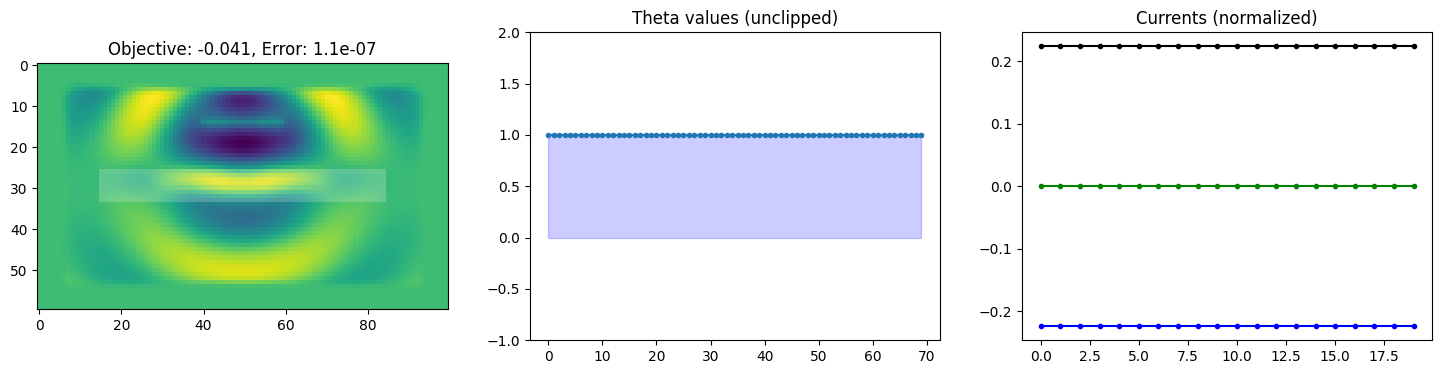

In [5]:
# Testing the model functions.
f, vis_field, vis_structure, vis_currents = model_fns(shape=(1, 100, 60), slab_thickness=8)

theta = np.ones((1, 70))
currents = -1 * np.ones((1, 20), np.complex128)

print(f'Objective: {f(theta, currents):.3f}')


plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
vis_field(theta, currents)
plt.subplot(1, 3, 2)
vis_structure(theta)
plt.subplot(1, 3, 3)
vis_currents(currents)

# Optimizing $f(z, b)$

We now perform gradient descent optimization on the objective function, optimizing for either $z$, $b$, or both.

In [6]:
# General optimization routine using JAX's experimental optimizers, see
# https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html.

def optimize(f, vis, params, num_steps, **opt_args):
  opt_init, opt_update, get_params = optimizers.sgd(**opt_args)
  opt_state = opt_init(params)

  def step(step, opt_state):
    value, grads = jax.value_and_grad(f)(get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

  values = []
  for i in range(num_steps):
    value, opt_state = step(i, opt_state)
    params = get_params(opt_state)
    values.append(value)
    vis_progress(values, params, vis)

  return params

def vis_progress(values, params, vis):
  clear_output(wait=True)
  plt.figure(figsize=(18, 5))

  plt.subplot(1, 2, 1)
  plt.title('Objective function')
  plt.xlabel('Step number')
  plt.plot(values, '.-')

  plt.subplot(1, 2, 2)
  vis(params)

  plt.show()


## Optimizing $b$

In [7]:
# Optimizer for the current source.
def optimize_currents(init_currents, num_steps, step_size):
  theta = np.zeros((1, 70))
  opt_currents = optimize(
      f=lambda currents: f(theta, currents),
      vis=vis_currents,
      params=init_currents,
      num_steps=num_steps,
      step_size=step_size)

  plt.figure(figsize=(18, 5))
  plt.subplot(1, 2, 1)
  vis_field(theta, init_currents, fn=np.abs)
  plt.subplot(1, 2, 2)
  vis_field(theta, opt_currents, fn=np.abs)


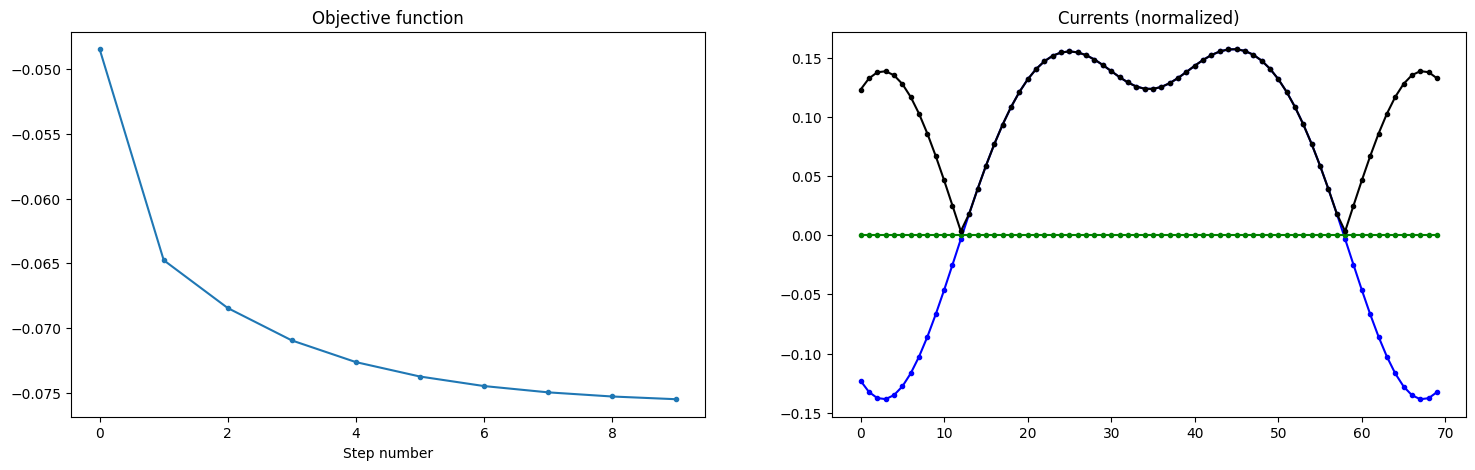

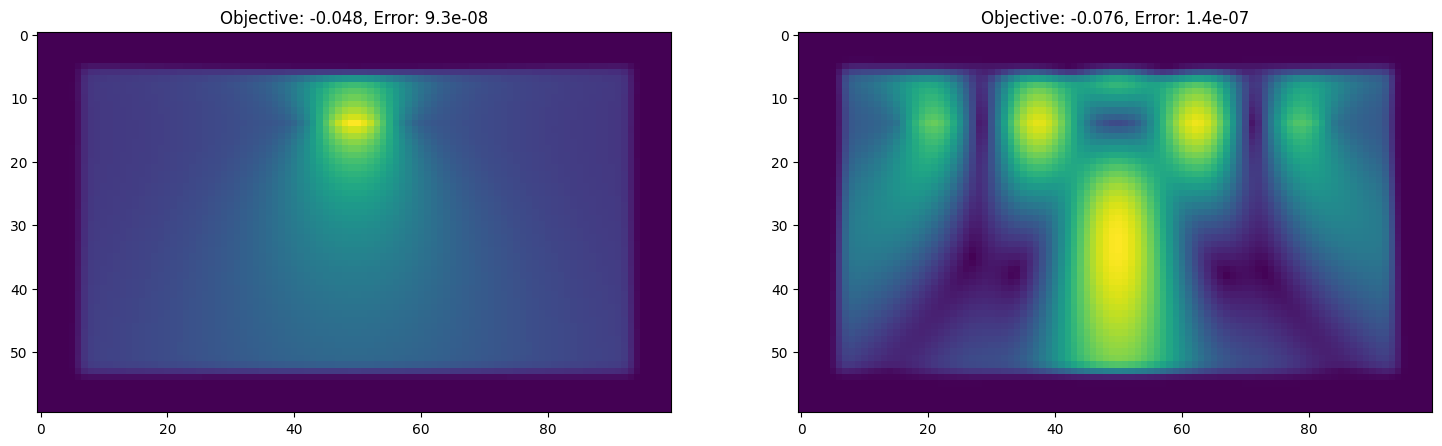

In [8]:
# Run the optimization.
pos = np.linspace(-5, 5, num=70)
init_currents = np.reshape(np.exp(-np.square(pos)), (1, 70))
optimize_currents(init_currents, 10, 1e3)


## Optimizing $z$

In [9]:
# Optimizer for the structure.
def optimize_theta(init_theta, num_steps, step_size):
  currents = np.ones((1, 20))
  opt_theta = optimize(
      f=lambda theta: f(theta, currents),
      vis=vis_structure,
      params=init_theta,
      num_steps=num_steps,
      step_size=step_size)

  plt.figure(figsize=(18, 5))
  plt.subplot(1, 2, 1)
  vis_field(init_theta, currents, fn=np.abs)
  plt.subplot(1, 2, 2)
  vis_field(opt_theta, currents, fn=np.abs)



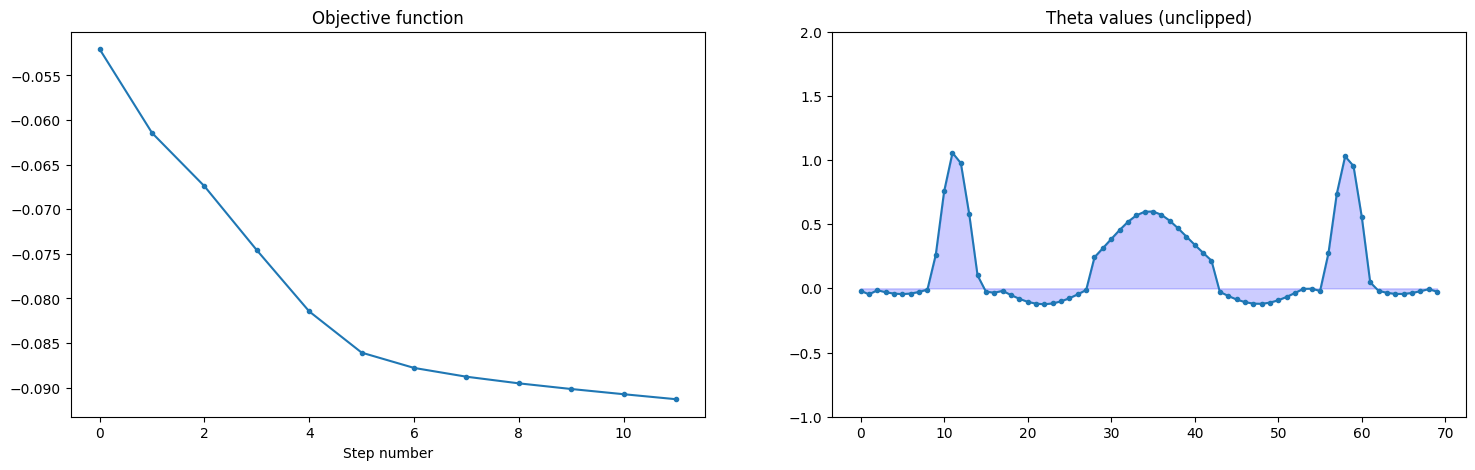

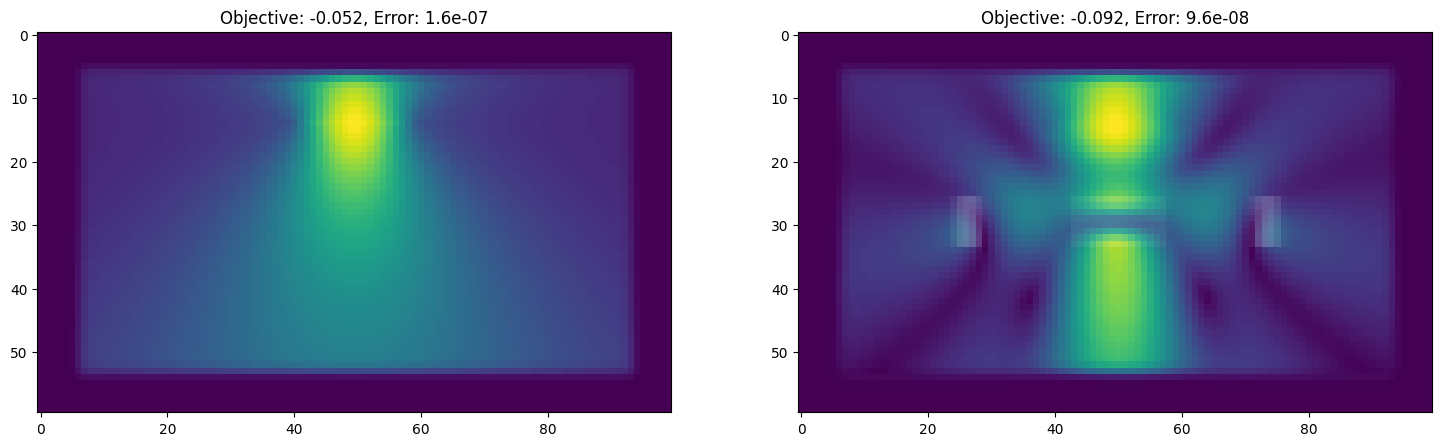

In [10]:
# Start with `theta=0` everywhere.
optimize_theta(
    init_theta=0.0 * np.ones((1, 70)),
    num_steps=12,
    step_size=3e1,
    )

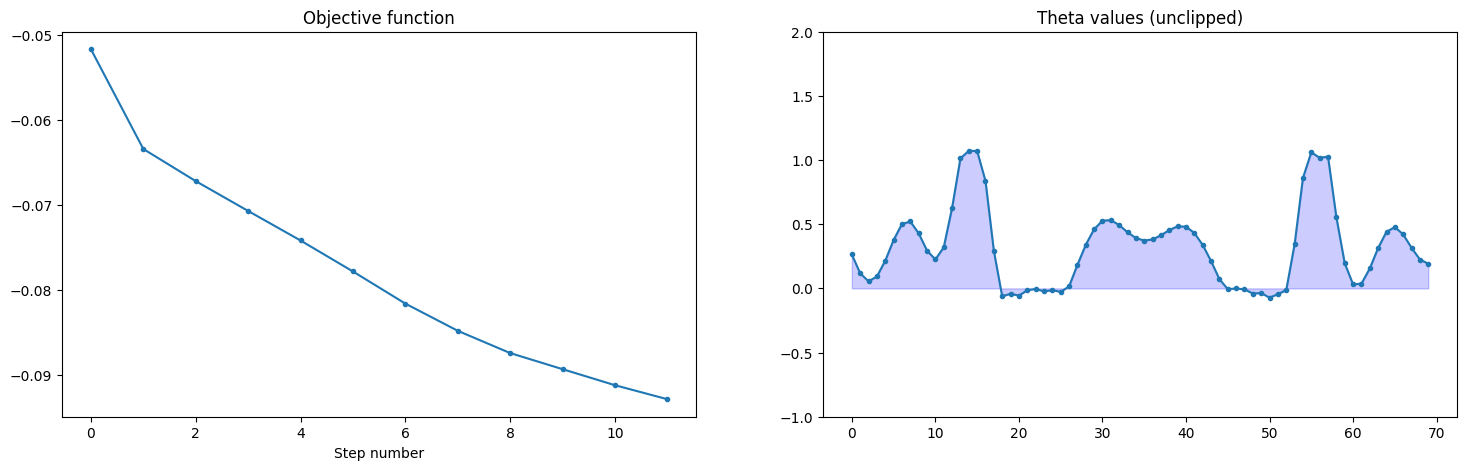

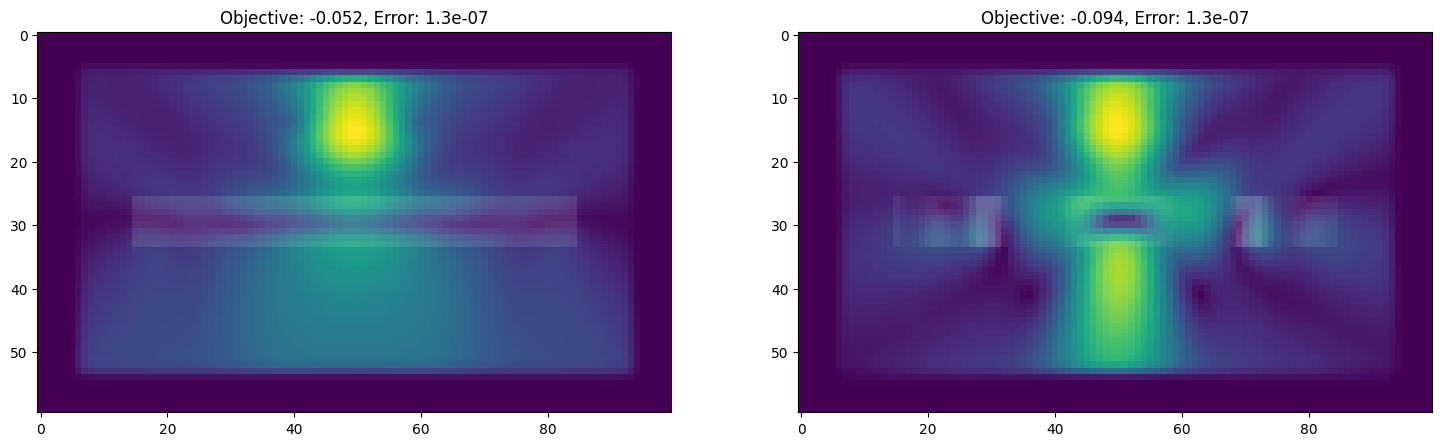

In [11]:
# Start with `theta=0.5` everywhere.
opt_theta = optimize_theta(
    init_theta=0.5 * np.ones((1, 70)),
    num_steps=12,
    step_size=3e1,
    )

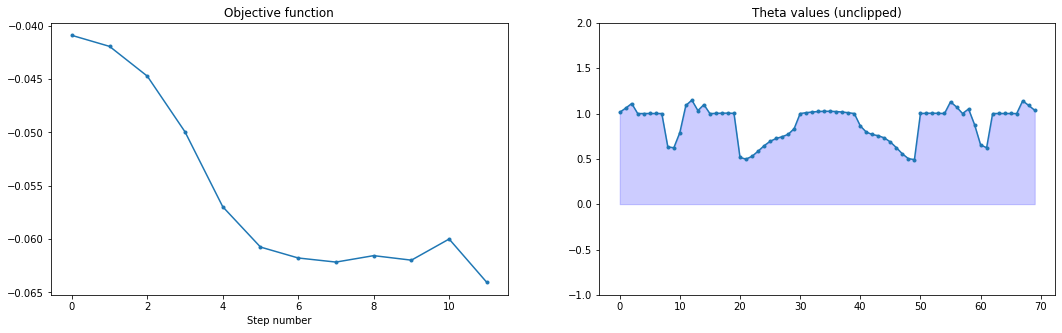

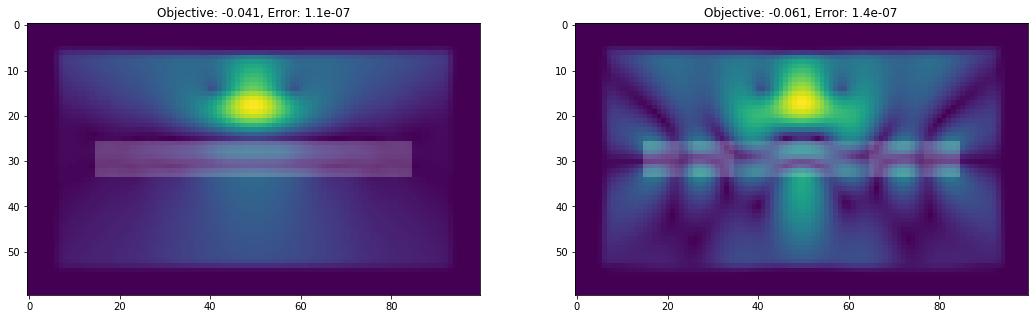

In [ ]:
# Start with `theta=1` everywhere.
opt_theta = optimize_theta(
    init_theta=np.ones((1, 70)),
    num_steps=12,
    step_size=2e1,
    )

## Optimizing both $z$ and $b$

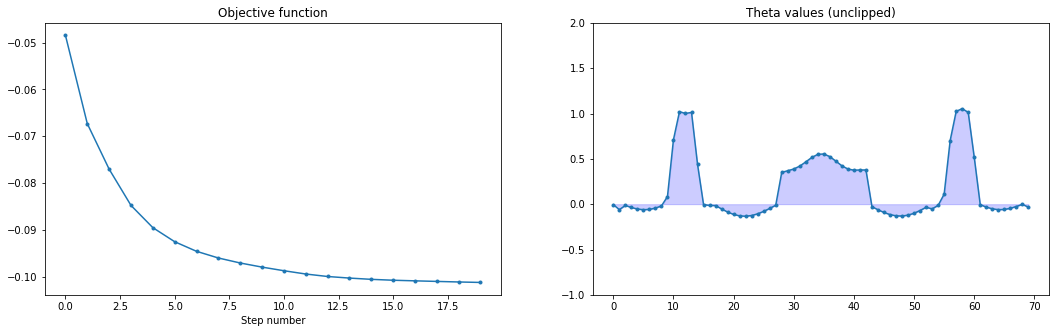

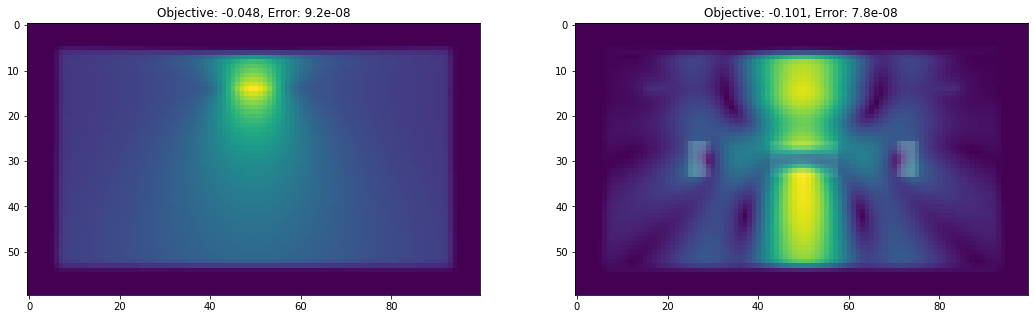

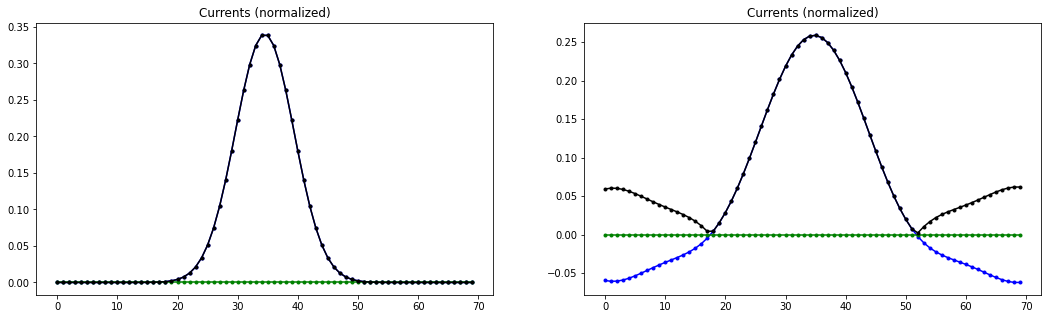

In [ ]:
# Optimizers for the current and structure separately and together.
def optimize_both(init, num_steps, step_size):
  def vis_just_structure(params):
    vis_structure(params[0])

  opt = optimize(
      f=lambda init: f(init[0], init[1]),
      vis=vis_just_structure,
      params=init,
      num_steps=num_steps,
      step_size=step_size)

  plt.figure(figsize=(18, 5))
  plt.subplot(1, 2, 1)
  vis_field(init[0], init[1], fn=np.abs)
  plt.subplot(1, 2, 2)
  vis_field(opt[0], opt[1], fn=np.abs)

  plt.figure(figsize=(18, 5))
  plt.subplot(1, 2, 1)
  vis_currents(init[1])
  plt.subplot(1, 2, 2)
  vis_currents(opt[1])

pos = np.linspace(-5, 5, num=70)
init_currents = np.reshape(np.exp(-np.square(pos)), (1, 70))
init_theta = np.zeros((1, 70))
optimize_both((init_theta, init_currents), 20, 3e1)
